In [ ]:
# !pip install xarray --upgrade

In [1]:
from datacube import Datacube
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from datacube.utils.geometry import assign_crs
import sys
sys.path.append('../dea-notebooks/Scripts')
from dea_datahandling import load_ard
from dea_dask import create_local_dask_cluster
from dea_temporal_statistics import fast_completion, smooth

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:45445 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 8 Memory: 61.42 GB


## Load Data

In [3]:
lat, lon = -33.2, 149.1
buffer = 0.05
time = ('2013', '2019')

In [4]:
dc = Datacube(app='whatevrr')

query = {'lon': (lon - buffer, lon + buffer),
         'lat': (lat - buffer, lat + buffer),
         'time': time,
         'measurements':['nbart_red', 'nbart_nir'],
         'output_crs' :'EPSG:3577',
         'resolution' : (-30, 30),
         'resampling' :{"fmask": "nearest", "*": "average"}}

In [5]:
ds = load_ard(dc=dc, 
              dask_chunks={'x':2000, 'y':2000, 'time':-1},
              products=['ga_ls8c_ard_3'],
              **query)
# print(ds)

Finding datasets
    ga_ls8c_ard_3
Applying pixel quality/cloud mask
Returning 170 time steps as a dask array


## Calculate std anomalies

In [6]:
ndvi = (ds.nbart_nir - ds.nbart_red) / (ds.nbart_nir + ds.nbart_red)

In [7]:
ndvi = ndvi.chunk({'time':-1}).interpolate_na(dim='time', method='linear',).resample(time="1W").interpolate("linear")
ndvi = ndvi.rolling(time=3, min_periods=1).mean().dropna("time")

In [8]:
climatology_mean = ndvi.groupby("time.week").mean("time")
climatology_std = ndvi.groupby("time.week").std("time")


In [9]:
stand_anomalies = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    ndvi.groupby("time.week"),
    climatology_mean,
    climatology_std,
    output_dtypes=[ndvi.dtype],
    dask="allowed"
)

In [10]:
stand_anomalies = stand_anomalies.compute()

/env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


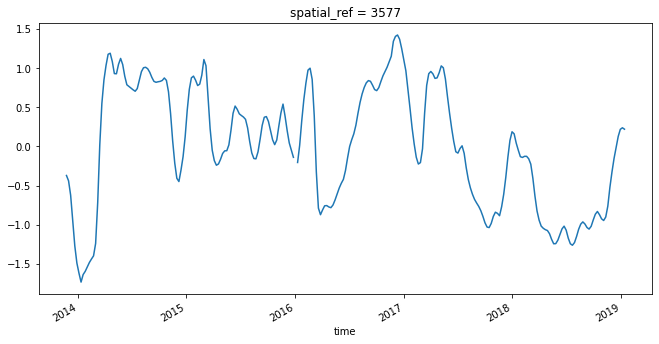

In [11]:
stand_anomalies.mean(['x','y']).plot(figsize=(11,5));

## Testing autocorrelation

Initially testing on the 1D example, once we understand we can explore the 3D example

In [12]:
zonal_mean = stand_anomalies.mean(['x','y'])
df = zonal_mean.drop('spatial_ref').drop('week').to_dataframe(name='stand_anomalies').dropna()

/env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


#### Check for Autocorrelation (ie correlation between adjacent timesteps)

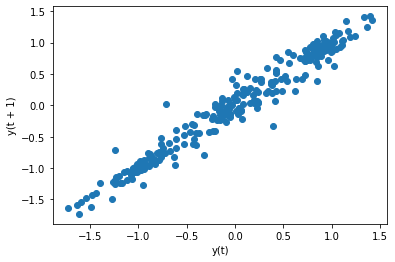

In [13]:
lag_plot(df)

#### Pearsons coefficient

In [14]:
values = pd.DataFrame(df.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.979567
t+1  0.979567  1.000000


### Make a forecast

predicted=-0.011299, expected=-0.012859
predicted=0.092964, expected=0.127096
predicted=0.272499, expected=0.217129
predicted=0.386008, expected=0.236928
predicted=0.373401, expected=0.218772
Test RMSE: 0.100


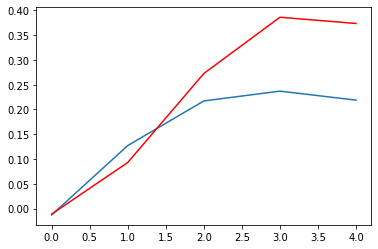

In [28]:
# create and evaluate an updated autoregressive model
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

# split dataset
X = df.values
train, test = X[1:len(X)-5], X[len(X)-5:]

# train autoregression
window = 100
model = AutoReg(train, lags=100)
model_fit = model.fit()
coef = model_fit.params

# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]

predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [ ]:
# stand_anomalies = stand_anomalies.drop('spatial_ref')
# template = stand_anomalies.transpose("y", "x", "time").chunk({'time':-1})
# stand_anomalies = stand_anomalies.chunk({'time':-1}).map_blocks(
#                             smooth,
#                             template=template
#                         )

In [ ]:
# quarter= {'JFM': [1,2,3],
#            'FMA': [2,3,4],
#            'MAM': [3,4,5],
#            'AMJ': [4,5,6],
#            'MJJ': [5,6,7],
#            'JJA': [6,7,8],
#            'JAS': [7,8,9],
#            'ASO': [8,9,10],
#            'SON': [9,10,11],
#            'OND': [10,11,12],
#            'NDJ': [11,12,1],
#            'DJF': [12,1,2],
#                       }

# def ndvi_climatology(ndvi, stat='mean'):
    
#     ndvi_var = []
#     for q in quarter:
        
#         ix=ndvi['time.month'].isin(quarter[q])
        
#         if stat=='std':
#             ndvi_clim=ndvi.where(ix, drop = True).std(dim='time')   
#         if stat=='mean':
#             ndvi_clim=ndvi.where(ix, drop = True).mean(dim='time') 
        
#         ndvi_clim=ndvi_clim.to_array(name=q).drop('variable').squeeze()
#         ndvi_var.append(ndvi_clim)

#     q_clim = xr.merge(ndvi_var)   
    
#     #assign back attributes
#     crs = ndvi.geobox.crs
#     q_clim = assign_crs(q_clim, str(crs))

#     return q_clim

# mean = ndvi_climatology(ndvi,stat='mean').compute()
# std = ndvi_climatology(ndvi,stat='std').compute()